<a href="https://colab.research.google.com/github/bobovnii/QML-QEC/blob/master/QEC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install qiskit

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 17.3MB 4.3MB/s 
     |████████████████████████████████| 61kB 22.4MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 983kB 48.5MB/s 
     |████████████████████████████████| 51kB 23.0MB/s 
     |████████████████████████████████| 5.3MB 41.4MB/s 
     |████████████████████████████████| 51kB 19.6MB/s 
     |████████████████████████████████| 71kB 25.9MB/s 
     |████████████████████████████████| 532kB 44.2MB/s 
     |████████████████████████████████| 21.7MB 27.1MB/s 
     |████████████████████████████████| 2.3MB 35.5MB/s 
     |████████████████████████████████| 61kB 27.0MB/s 
     |████████████████████████████████| 61kB 23.2MB/s 
  Created wheel for qiskit: filename=qiskit-0.13.0-cp36-none-any.whl size=1399 sha256=9ab08d7f44102e703ba11d24e6ecd49e060239231c0c9044d74cafc482116837
  Stored in directory: /root/.cache/pip/wheels/4e/f0/27/e914f739445603a

In [0]:
from qiskit import Aer, IBMQ, execute
from qiskit.providers.aer import noise
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.ibmq.exceptions import IBMQAccountError
import math

In [0]:
APIkey='c6fc793df7449ee95182f459d173e969cbe30ebbb25a0ad660fc4e32c3e8550fffedb2d772216a2cd5430f81bd0c2793b0f2428dec9f4d03e579d4e0158bdbc3'

In [0]:




class Denoiser():
    def __init__(self, n, APIkey):
        self.n = n

        # Load IBMQ backend used for noise modeling
        try:
            provider = IBMQ.enable_account(APIkey)
        except IBMQAccountError as e:
            provider = IBMQ.get_provider(hub='ibm-q')
            print(e)
        device = provider.get_backend('ibmq_ourense')
        properties = device.properties()

        # Generate noise model from device
        self.noise_model = noise.device.basic_device_noise_model(properties)

        # Select the QasmSimulator from the Aer provider
        self.simulator = Aer.get_backend('qasm_simulator')

    def get_dist(self, psi, theta, shots=1, noise=False, init=True):
        # reset to new circuit
        self.q = QuantumRegister(self.n)
        self.c = ClassicalRegister(self.n)
        self.qc = QuantumCircuit(self.q, self.c)

        self.qc.initialize(psi, self.q)
        self._qft_inv()

        # Select the statevector simulator for noise-free simulation
        simulator = Aer.get_backend('statevector_simulator')
        self.psi = execute(self.qc, simulator).result().get_statevector()

        # ------------------------------------------------------------- #

        self.q = QuantumRegister(self.n)
        self.c = ClassicalRegister(self.n)
        self.qc = QuantumCircuit(self.q, self.c)
        
        # run noisy part of circuit
        if init:
            self.qc.initialize(self.psi, self.q)
        self._denoise(theta)
        
        self.qc.u3(0,0,random.random(),0)
        
        self._qft()
        self.qc.measure(self.q, self.c)

        if noise:
            result = execute(self.qc, self.simulator, noise_model=self.noise_model, shots=shots).result()
        else:
            result = execute(self.qc, self.simulator, shots=shots).result()

        counts = result.get_counts()
        for i in range(2**self.n):
            #print("{{0:0{0}b}}".format(self.n).format(i))
            if "{{0:0{0}b}}".format(self.n).format(i) not in counts:
                counts["{{0:0{0}b}}".format(self.n).format(i)] = 0

        return [value/shots for (key, value) in sorted(counts.items())]

    def _qft(self):
        """n-qubit QFT on q in circ."""
        for j in range(self.n):
            self.qc.h(self.q[j])
            for k in range(j+1, self.n):
                self.qc.cu1(math.pi/float(2**(k-j)), self.q[k], self.q[j])
            self.qc.barrier()

    def _qft_inv(self):
        """n-qubit QFT on q in circ."""
        for j in range(self.n-1, -1, -1):
            for k in range(self.n-1, j, -1):
                self.qc.cu1(-math.pi/float(2**(k-j)), self.q[k], self.q[j])
            self.qc.h(self.q[j])
            self.qc.barrier()

    def _denoise(self, theta):
        for j in range(self.n):
            x, y, z = theta[j]
            self.qc.u3(x, y, z, self.q[j])

In [403]:
denoiser = Denoiser(2,APIkey)

'An IBM Q Experience v2 account is already enabled.'


In [0]:
out = denoiser.get_dist([1,0,0,0,0,0,0,0],[(0,0,0),(0,0,0),(0,0,0)])

In [0]:
out1 = denoiser.get_dist([1,0,0,0],[(0.1,0,0),(0,0,0)])

In [0]:
out = denoiser.get_dist([1,0,0,0],[(0,0,0),(0,0,0)])

In [359]:
out

[0.923, 0.032, 0.0, 0.045]

In [167]:
out1

[0.978, 0.005, 0.015, 0.002]

In [287]:
bool(random.getrandbits(1))

False

In [0]:
pip install noisyopt

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from noisyopt import minimizeCompass

In [0]:
out = np.array((0, 0, 0, 0, 0, 0, 0, 0))
def func(Theta,x):
    out = denoiser.get_dist(x,[(Theta[0],Theta[1],Theta[2]),(Theta[3],Theta[4],Theta[5]),(Theta[6],Theta[7],Theta[8])])
    return out

In [0]:
import  random

In [0]:
out = np.array((0, 0, 0, 0))
def func(Theta,x):
    b=[0.1*random.random(),0.1*random.random(),0.1*random.random(),0.1*random.random()]
    out = sum(np.array(denoiser.get_dist(x,[(Theta[0],Theta[1],Theta[2]),(Theta[3],Theta[4],Theta[5])])) for i in range(100))/100
    #out += b
    return out

In [410]:
func([0,0,0,0,0,0],[1,0,0,0])

array([0.92572, 0.03751, 0.     , 0.03677])

In [409]:
func([0,0,-0.5,0,0,0],[1,0,0,0])

array([0.97849, 0.01116, 0.     , 0.01035])

In [266]:
func([3.1,0,0,0,0,0],[1,0,0,0])

array([0.984, 0.003, 0.013, 0.   ])

In [0]:
  

  
x1 = np.array((1, 0, 0, 0,0,0,0,0))
x2 = np.array((0, 1, 0, 0,0,0,0,0))
x3 = np.array((0, 0, 1, 0,0,0,0,0))
x4 = np.array((0, 0, 0, 1,0,0,0,0))
x5 = np.array((0, 0, 0, 0,1,0,0,0))
x6 = np.array((0, 0, 0, 0,0,1,0,0))
x7 = np.array((0, 0, 0, 0,0,0,1,0))
x8 = np.array((0, 0, 0, 0,0,0,0,1))
xx = [x1,x2,x3,x4,x5,x6,x7,x8] 

  
def Los2(Theta):
  
    return sum(np.linalg.norm(func(Theta,xx[i])-xx[i]) for i in range(7) )
  

In [0]:

  
x1 = np.array((1, 0, 0, 0))
x2 = np.array((0, 1, 0, 0))
x3 = np.array((0, 0, 1, 0))
x4 = np.array((0, 0, 0, 1))

xx = [x1,x2,x3,x4] 

  
def Los2(Theta):
  
    return sum(np.linalg.norm(func(Theta,xx[i])-xx[i]) for i in range(3) )
  
#def Los2(Theta):
  
#    return np.linalg.norm(func(Theta,xx[0])-xx[0])

In [180]:
Los2([0,0,0,0,0,0,0,0,0])

0.0848449142861827

In [0]:
def Los3(test):
    return Los2([0,0,test,0,0,0])
  


In [366]:
Los3(0)


0.2942270524022056

In [0]:
def frange(start, stop, step):
      i = start
      while i < stop:
        y = Los3(i,0,0)
        print y
        i += step

In [168]:
y = x*x

plot[x ,y ]

NameError: ignored

In [0]:






t = np.arange(0.0, 2.0, 0.01)

y = frange(0.0, 2.0, 0.01)

i = -0.2
j = -0.5
k = -0.5
while i < 0.2:
  j = -0.2
  while j < 0.2:
    k = -0.2
    while k < 0.2:
        y = Los3([i,j,k])
        print(i,j,k)
        print(y)
        
        k += 0.1
    j += 0.1
  i += 0.1
    



In [262]:
Los3([0])

3.644221698036435

In [263]:
Los3([0,0.1,-0.1])

0.13621805775737056

In [88]:
np.pi

3.141592653589793

In [0]:
boundsNew = [[-np.pi, np.pi], [-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi]]

In [0]:
res = minimizeCompass(Los3, x0=[1,1,1],bounds=[[-np.pi, np.pi],[-np.pi, np.pi],[-np.pi, np.pi]], deltatol=0.1, paired=False)

In [0]:
res = minimizeCompass(Los3, x0=[1],bounds=[[-np.pi, np.pi]], deltatol=0.1, paired=False)

In [0]:
res = minimizeCompass(Los3, x0=[1,1,1],bounds=[[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]], deltatol=0.1, paired=False)

In [368]:
res

    free: array([False])
     fun: 0.07433522301876042
   funse: 0.00697201346196615
 message: 'convergence within deltatol'
    nfev: 270
     nit: 5
 success: True
       x: array([-0.5])

In [100]:
res = minimizeCompass(Los2, x0=[0,0,0,0,0,0,0,0,0],bounds=boundsNew, deltatol=0.2, paired=False)

KeyboardInterrupt: ignored

In [413]:
func([0,0,0,0,0,0],[1,0,0,0])[0]

0.9320899999999999

In [377]:
func([0,0,-0,5,0,0,0],[1,0,0,0])

array([0.531, 0.097, 0.283, 0.089])

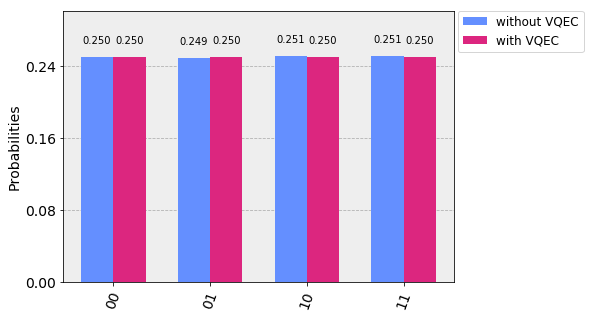

In [414]:




a = {'00':func([0,0,0,0,0,0],[1,0,0,0])[0],'01':func([0,0,0,0,0,0],[0,1,0,0])[1],'10':func([0,0,0,0,0,0],[0,0,1,0])[2],'11':func([0,0,0,0,0,0],[0,0,0,1])[3]}

b = {'00':func([0,0,-0.5,0,0,0],[1,0,0,0])[0],'01':func([0,0,-0.5,0,0,0],[0,1,0,0])[1],'10':func([0,0,-0.5,0,0,0],[0,0,1,0])[2],'11':func([0,0,-0.5,0,0,0],[0,0,0,1])[3]}


legend = ['without VQEC','with VQEC']
plot_histogram([a,b],legend=legend)

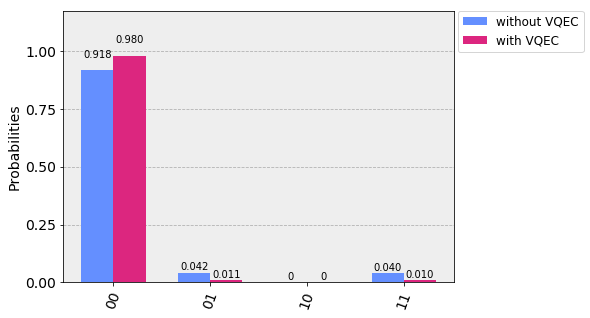

In [415]:
a = {'00':func([0,0,0,0,0,0],[1,0,0,0])[0],'01':func([0,0,0,0,0,0],[1,0,0,0])[1],'10':func([0,0,0,0,0,0],[1,0,0,0])[2],'11':func([0,0,0,0,0,0],[1,0,0,0])[3]}

b = {'00':func([0,0,-0.5,0,0,0],[1,0,0,0])[0],'01':func([0,0,-0.5,0,0,0],[1,0,0,0])[1],'10':func([0,0,-0.5,0,0,0],[1,0,0,0])[2],'11':func([0,0,-0.5,0,0,0],[1,0,0,0])[3]}


legend = ['without VQEC','with VQEC']
plot_histogram([a,b],legend=legend)

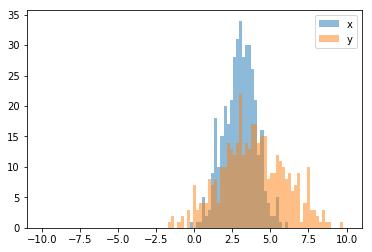

In [385]:
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = np.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()